In [1]:
import polars as pl
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
from pathlib import Path
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import altair as alt
## Sklearn package
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error 
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 99

In [2]:
train_logs = pd.read_csv("data/raw/train_logs.csv")
train_scores = pd.read_csv("data/raw/train_scores.csv")
train_dataset = train_logs.merge(train_scores, on='id', how='inner')

## Train Test Splitting

In [3]:
train_df, test_df = train_test_split(train_dataset, test_size=0.2, random_state=123)
train_df.shape

(6724718, 12)

## Generate Features from train logs

In [4]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 6724718 entries, 1733243 to 4967934
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               object 
 1   event_id         int64  
 2   down_time        int64  
 3   up_time          int64  
 4   action_time      int64  
 5   activity         object 
 6   down_event       object 
 7   up_event         object 
 8   text_change      object 
 9   cursor_position  int64  
 10  word_count       int64  
 11  score            float64
dtypes: float64(1), int64(6), object(5)
memory usage: 667.0+ MB


,event_id,down_time,up_time,action_time,cursor_position,word_count,score
count,6.724718e+06,6.724718e+06,6.724718e+06,6.724718e+06,6.724718e+06,6.724718e+06,6.724718e+06
mean,2.067431e+03,7.934946e+05,7.935927e+05,9.809989e+01,1.222872e+03,2.314426e+02,3.992168e+00
std,1.588124e+03,5.149524e+05,5.149502e+05,2.422870e+02,9.485225e+02,1.758954e+02,9.917137e-01
min,1.000000e+00,1.060000e+02,2.520000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01
25%,8.520000e+02,3.731730e+05,3.732670e+05,6.600000e+01,4.990000e+02,9.600000e+01,3.500000e+00
50%,1.726000e+03,7.207530e+05,7.208520e+05,9.300000e+01,1.043000e+03,2.000000e+02,4.000000e+00
75%,2.925000e+03,1.162892e+06,1.162992e+06,1.220000e+02,1.706000e+03,3.270000e+02,4.500000e+00
max,1.287600e+04,8.313630e+06,8.313707e+06,4.474700e+05,7.802000e+03,1.326000e+03,6.000000e+00


In [5]:
score_counts = train_df['score'].value_counts().reset_index()
score_counts.columns = ['score', 'count'] 

chart = alt.Chart(score_counts).mark_bar().encode(
    x=alt.X('score:O', axis=alt.Axis(title='Score')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    color=alt.Color('score:N', 
                    scale=alt.Scale(scheme='tableau20'),
                    legend=alt.Legend(title="Score Values"))
)

chart  

alt.Chart(...)

In [6]:
average_events_train = train_df.groupby("id").count()["event_id"].mean().round(0)
print(f'The average number of events per essay in the train dataset is: {average_events_train}')

average_events_test = test_df.groupby("id").count()["event_id"].mean().round(0)
print(f'The average number of events per essay in the test dataset is: {average_events_test}')

train_event_counts = train_df.groupby('id')['event_id'].count().reset_index()
train_event_counts.columns = ['id', 'event_count']

test_event_counts = test_df.groupby('id')['event_id'].count().reset_index()
test_event_counts.columns = ['id', 'event_count']

train_chart = alt.Chart(train_event_counts).mark_bar().encode(
    alt.X("event_count:Q", bin=alt.Bin(maxbins=30), title="Number of Events"),
    alt.Y('count()', title="Number of Essays"),
    tooltip=[alt.Tooltip('count()', title='Number of Essays'), alt.Tooltip('event_count', title='Events')]
).properties(
    title="Distribution of the Number of Events per Essay - Train Dataset"
)

test_chart = alt.Chart(test_event_counts).mark_bar().encode(
    alt.X("event_count:Q", bin=alt.Bin(maxbins=30), title="Number of Events"),
    alt.Y('count()', title="Number of Essays"),
    tooltip=[alt.Tooltip('count()', title='Number of Essays'), alt.Tooltip('event_count', title='Events')]
).properties(
    title="Distribution of the Number of Events per Essay - Test Dataset"
)

train_chart.display()
test_chart.display()

The average number of events per essay in the train dataset is: 2721.0
The average number of events per essay in the test dataset is: 680.0


alt.Chart(...)

alt.Chart(...)

In [7]:
numerical_columns = train_df.select_dtypes(include=['int64', 'float64'])

spearman_corr_matrix = numerical_columns.corr(method='spearman').reset_index()

# Melt the correlation matrix into a long-form DataFrame
corr_df_long = spearman_corr_matrix.melt('index')

# Create the heatmap in Altair
heatmap = alt.Chart(corr_df_long).mark_rect().encode(
    x=alt.X('index:O', title=None), 
    y=alt.Y('variable:O', title=None), 
    color='value:Q', 
    tooltip=[
        alt.Tooltip('index', title='Variable 1'),
        alt.Tooltip('variable', title='Variable 2'),
        alt.Tooltip('value', title='Correlation', format=".2f")
    ]
).properties(
    title='Spearman Correlation Matrix',
    width=500,
    height=500
)

text = heatmap.mark_text(baseline='middle').encode(
    text=alt.Text('value:Q', format='.2f'),
    color=alt.condition(
        alt.datum.value > 0.5,
        alt.value('white'),
        alt.value('black')
    )
)

final_chart = heatmap + text

final_chart.display()

alt.LayerChart(...)

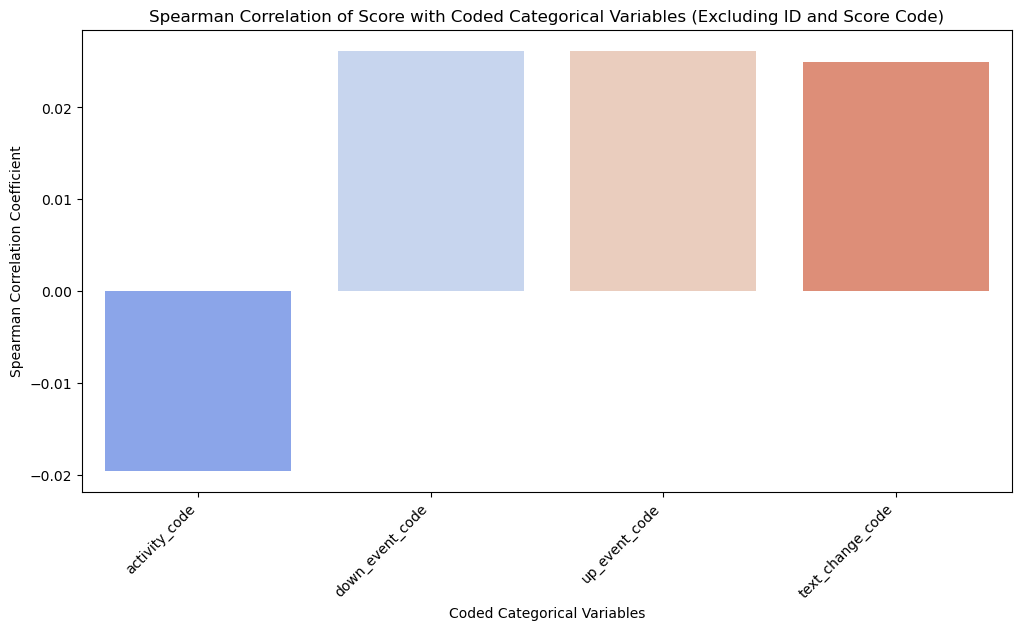

In [8]:
category_columns = train_df.select_dtypes(include=['object']).drop('id', axis=1)

for col in category_columns:
    train_df[col + '_code'] = train_df[col].astype('category').cat.codes

coded_category_columns = train_df.filter(regex='_code$')
coded_category_columns = coded_category_columns.drop(['id_code', 'score_code'], axis=1, errors='ignore')  

spearman_corr_coded_category = coded_category_columns.corrwith(train_df['score'], method='spearman')

plt.figure(figsize=(12, 6))
sns.barplot(x=spearman_corr_coded_category.index, y=spearman_corr_coded_category.values, palette='coolwarm', dodge=False)
plt.title('Spearman Correlation of Score with Coded Categorical Variables (Excluding ID and Score Code)')
plt.xlabel('Coded Categorical Variables')
plt.ylabel('Spearman Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

In [9]:
train_logs = pl.scan_csv("data/raw/train_logs.csv")

In [10]:
class FeatureExtractor():
    def __init__(self, logs):
        self.logs = logs # Training logs
        
    def count_by_values(self, colname, used_cols):
        fts = self.logs.select(pl.col('id').unique(maintain_order=True))
        for i, col in enumerate(used_cols):
            tmp_logs = self.logs.group_by('id').agg(
                            pl.col(colname).is_in([col]).sum().alias(f'{colname}_{i}_cnt')
                                    )
            fts  = fts.join(tmp_logs, on='id', how='left') 
        return fts
    
    def create_count_by_values_feats(self):
        activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.',
                       ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        text_changes = ['q', ' ', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']        
        #=== Create the feature columns using count by values ===
        df = self.count_by_values('activity', activities) # Create 'activity' column
        df = df.join(self.count_by_values('text_change', text_changes), on='id', how='left') 
        df = df.join(self.count_by_values('down_event', events), on='id', how='left') 
        df = df.join(self.count_by_values('up_event', events), on='id', how='left')
        # print(df.collect().head())
        return df

    # Create the features 
    def create_input_words_feats(self):
        # Filter no changes 
        df = self.logs.filter((~pl.col('text_change').str.contains('=>')) & (pl.col('text_change') != 'NoChange'))
        # Aggregate the text changes by id
        df = df.group_by('id').agg(pl.col('text_change').str.concat('').str.extract_all(r'q+'))
        # creates only two columns ('id' and 'text_change') 
        df = df.with_columns(input_word_count=pl.col('text_change').list.lengths(),
                             input_word_length_mean=pl.col('text_change').apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_max=pl.col('text_change').apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_std=pl.col('text_change').apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_median=pl.col('text_change').apply(lambda x: np.median([len(i) for i in x] if len(x) > 0 else 0)),
                             input_word_length_skew=pl.col('text_change').apply(lambda x: skew([len(i) for i in x] if len(x) > 0 else 0)))
        df = df.drop('text_change') # Remove 'text_change' to avoid including duplicated `text_change` column
        return df
    
    # Create the statistical numeric features (e.g. sum, median, mean min, 0.5_quantile)
    def create_numeric_feats(self):
        num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
        df = self.logs.group_by("id").agg(pl.sum('action_time').suffix('_sum'),
                                                pl.mean(num_cols).suffix('_mean'),
                                                pl.std(num_cols).suffix('_std'),
                                                pl.median(num_cols).suffix('_median'), pl.min(num_cols).suffix('_min'), pl.max(num_cols).suffix('_max'),
                                                pl.quantile(num_cols, 0.5).suffix('_quantile'))
        return df
    
    def create_categorical_feats(self):
        df  = self.logs.group_by("id").agg(
                pl.n_unique(['activity', 'down_event', 'up_event', 'text_change']))
        return df
    
    # Create the idle time features 
    def create_idle_time_feats(self):
        df = self.logs.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
        df = df.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
        df = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
        df = df.group_by("id").agg(inter_key_largest_lantency = pl.max('time_diff'),
                                   inter_key_median_lantency = pl.median('time_diff'),
                                   mean_pause_time = pl.mean('time_diff'),
                                   std_pause_time = pl.std('time_diff'),
                                   total_pause_time = pl.sum('time_diff'),
                                   pauses_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 0.5) & (pl.col('time_diff') < 1)).count(),
                                   pauses_1_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1) & (pl.col('time_diff') < 1.5)).count(),
                                   pauses_1_half_sec = pl.col('time_diff').filter((pl.col('time_diff') > 1.5) & (pl.col('time_diff') < 2)).count(),
                                   pauses_2_sec = pl.col('time_diff').filter((pl.col('time_diff') > 2) & (pl.col('time_diff') < 3)).count(),
                                   pauses_3_sec = pl.col('time_diff').filter(pl.col('time_diff') > 3).count(),)
        return df
    
    # Create p-bursts features using up and down time and activity
    def create_p_bursts_feats(self):
        df = self.logs.with_columns(pl.col('up_time').shift().over('id').alias('up_time_lagged'))
        df = df.with_columns((abs(pl.col('down_time') - pl.col('up_time_lagged')) / 1000).fill_null(0).alias('time_diff'))
        df = df.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
        df = df.with_columns(pl.col('time_diff')<2)
        df = df.with_columns(pl.when(pl.col("time_diff") & pl.col("time_diff").is_last()).then(pl.count()).over(pl.col("time_diff").rle_id()).alias('P-bursts'))
        df = df.drop_nulls()
        df = df.group_by("id").agg(pl.mean('P-bursts').suffix('_mean'),
                                   pl.std('P-bursts').suffix('_std'),
                                   pl.count('P-bursts').suffix('_count'),
                                   pl.median('P-bursts').suffix('_median'),
                                   pl.max('P-bursts').suffix('_max'),
                                   pl.first('P-bursts').suffix('_first'),
                                   pl.last('P-bursts').suffix('_last'))
        return df
    
    # Create r-burst features using activity 
    def create_r_bursts_feats(self):
        df = self.logs.filter(pl.col('activity').is_in(['Input', 'Remove/Cut']))
        df = df.with_columns(pl.col('activity').is_in(['Remove/Cut']))
        df = df.with_columns(pl.when(pl.col("activity") & pl.col("activity").is_last()).then(pl.count()).over(pl.col("activity").rle_id()).alias('R-bursts'))
        df = df.drop_nulls()
        df = df.group_by("id").agg(pl.mean('R-bursts').suffix('_mean'),
                                   pl.std('R-bursts').suffix('_std'), 
                                   pl.median('R-bursts').suffix('_median'),
                                   pl.max('R-bursts').suffix('_max'),
                                   pl.first('R-bursts').suffix('_first'),
                                   pl.last('R-bursts').suffix('_last'))
        return df
    
    # Main function creates all 122 features
    def create_feats(self):
        feats = self.create_count_by_values_feats()  # 52 columns in total
#         print(f"< Count by values features > {len(feats.columns)}")        
        feats = feats.join(self.create_input_words_feats(), on='id', how='left')  # 58 columns
#         print(f"< Input words stats features > {len(feats.columns)}")
        feats = feats.join(self.create_numeric_feats(), on='id', how='left') # 89 columns
#         print(f"< Numerical features > {len(feats.columns)}")
        feats = feats.join(self.create_categorical_feats(), on='id', how='left') # 93 columns      
#         print(f"< Categorical features > {len(feats.columns)}")
        feats = feats.join(self.create_idle_time_feats(), on='id', how='left') # 103 columns
#         print(f"< Idle time features > {len(feats.columns)}")
        feats = feats.join(self.create_p_bursts_feats(), on='id', how='left') # 110 columns
#         print(f"< P-bursts features > {len(feats.columns)}")
        feats = feats.join(self.create_r_bursts_feats() , on='id', how='left') # 116 columns
#         print(f"< R-bursts features > {len(feats.columns)}")        
        return feats # 116 features 

In [11]:
fe = FeatureExtractor(train_logs)
train_feats = fe.create_feats() # Extract features from trainning logs (polars df)
train_feats = train_feats.collect().to_pandas() # Convert polars df to pandas df
train_feats.to_csv("train_feats_0.csv")
# print(train_feats.describe())
train_logs = train_logs.collect().to_pandas()  # Convert polars df to pandas df
del fe